In case you don't have tokenized books in the `./res` folder,

download this file:
https://drive.google.com/uc?export=download&id=1HZxpWE_T-ZhZyLAB83wO7c7dFR6_xe7T
   
and put its content to the `./res` folder

To use pre-trained word embeddings, you have to use this fork of gensim:
    https://github.com/jhlau/doc2vec
        
If you set `pretrained_emb` to None, the word embeddings are trained and the code works with the newest version of gensim


In [1]:
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import pickle
import time
import gensim
import gensim.models as g
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec

from IPython.display import display, clear_output
import logging
logger = logging.getLogger().setLevel('INFO')
from src.utils import pickle_partial, unpickle, load_snippets

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier

import multiprocessing
cores = multiprocessing.cpu_count()
print(gensim.__version__)

3.4.0


In [2]:
snippet_length = 200

In [3]:
vector_size = 300
dim = vector_size
alpha = 0.015
alpha_coeff = 0.8
INCLUDE_BOOK_VECTORS = False
window_size = 2
glove = 1
min_count = 5

In [4]:
dm = 0
negative_size = 5
sampling_threshold = 1e-5
worker_count = cores
#pretrained_emb = '../res/glove.6B.300d3.txt' # None if use without pretrained embeddings
pretrained_emb = None

In [5]:
train_texts, test_texts, y_train, y_test, ids_train, ids_test = load_snippets(doc_size=snippet_length,
                                                                      word_tokenized=True,
                                                                      return_doc_ids=True)

train, val, y_tr_, y_val, ids_tr, ids_val = train_test_split(train_texts, y_train, ids_train, test_size=0.1, random_state=42)
# including genre tag (label) as well
train_tagged_docs = [TaggedDocument(t, [label, i]) for t, i, label in zip(train, ids_tr, y_tr_)]

(191363,)
(33771,)


In [6]:
doc2vec = g.Doc2Vec(train_tagged_docs, alpha=alpha, size=vector_size, window=window_size,
                  min_count=min_count, sample=sampling_threshold,
                  workers=worker_count, hs=0, dm=dm,
                  negative=negative_size, dbow_words=1,
                  pretrained_emb=pretrained_emb,
                  iter=1)

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/gensim/models/doc2vec.py:362: UserWarning: The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.
  warnings.warn("The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.")
/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/gensim/models/doc2vec.py:366: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
INFO:gensim.models.doc2vec:collecting all words and their counts
INFO:gensim.models.doc2vec:PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
INFO:gensim.models.doc2vec:PROGRESS: at example #10000, processed 437492 words (2003021/s), 29947 word types, 10014 tags
INFO:gensim.models.doc2vec:PROGRESS: at 

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 4 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 3 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 7529984 raw words (2124517 effective words) took 39.5s, 53843 effective words/s
INFO:gensim.models.base_any2vec:training on a 7529984 raw words (2124517 effective words) took 39.5s, 53828 effective words/s


In [7]:
result = dict()
genre_list = sorted(list(set(y_train)))
le = LabelEncoder()
y_tr = le.fit_transform(y_train)

In [8]:
epoch = 0
epochs_wo_improvement = 0
best_score = 0
alpha_iter = alpha
max_epoch = 100

for i in range(max_epoch):
    np.random.shuffle(train_tagged_docs)
    doc2vec.alpha = alpha_iter
    doc2vec.train(train_tagged_docs,
              total_examples=doc2vec.corpus_count,
              epochs=1,
              report_delay=10.0)  
    
    epoch += 1
    X_val = np.array([doc2vec.infer_vector(t) for t in val])
    genre_vectors = np.array([doc2vec.docvecs[x] for x in genre_list])
    sims = cosine_similarity(X_val, genre_vectors)
    y_val_pred = np.array(genre_list)[sims.argmax(axis=1)]
    acc = accuracy_score(y_val, y_val_pred).round(4)
    f1_sc = f1_score(y_val, y_val_pred, average='macro').round(4)
    result[epoch] = f1_sc
    print(result)

    doc2vec.epochs_trained = epoch
    
    #needed parameters to load that with newer gensim version
    doc2vec.running_training_loss = 0
    doc2vec.min_alpha_yet_reached = 0
    doc2vec.model_trimmed_post_training = 0
    doc2vec.docvecs.vector_size = doc2vec.vector_size

    if result[epoch] < best_score:
        if epochs_wo_improvement >= 2:
            print("Stop Training")
            break
            #raise Exception("Stopping training.")
        else:
            epochs_wo_improvement += 1
    else:
        epochs_wo_improvement = 0
        best_score = result[epoch]
        doc2vec.best_epoch = epoch
        doc2vec.save('/var/tmp/best_doc2vec')
    alpha_iter *= alpha_coeff
    

INFO:gensim.models.base_any2vec:training model with 8 workers on 35639 vocabulary and 300 features, using sg=1 hs=0 sample=1e-05 negative=5 window=2
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 2.25% examples, 33213 words/s, in_qsize 15, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 24.51% examples, 45038 words/s, in_qsize 15, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 65.07% examples, 64060 words/s, in_qsize 15, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 97.66% examples, 65544 words/s, in_qsize 15, out_qsize 0
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 7 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 6 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 5 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 4 more threads
INFO:gensim.models.base_any2vec:worker threa

{1: 0.1036}


INFO:gensim.utils:storing np array 'vectors' to /var/tmp/best_doc2vec.wv.vectors.npy
INFO:gensim.utils:storing np array 'vectors_docs' to /var/tmp/best_doc2vec.docvecs.vectors_docs.npy
INFO:gensim.utils:saved /var/tmp/best_doc2vec
INFO:gensim.models.base_any2vec:training model with 8 workers on 35639 vocabulary and 300 features, using sg=1 hs=0 sample=1e-05 negative=5 window=2
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 4.38% examples, 91310 words/s, in_qsize 15, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 41.35% examples, 79533 words/s, in_qsize 15, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 89.57% examples, 90420 words/s, in_qsize 15, out_qsize 0
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 7 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 6 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 5 more threads
INFO:gensim.mod

{1: 0.1036, 2: 0.2042}


INFO:gensim.utils:storing np array 'vectors_docs' to /var/tmp/best_doc2vec.docvecs.vectors_docs.npy
INFO:gensim.utils:saved /var/tmp/best_doc2vec
INFO:gensim.models.base_any2vec:training model with 8 workers on 35639 vocabulary and 300 features, using sg=1 hs=0 sample=1e-05 negative=5 window=2
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 1.99% examples, 42015 words/s, in_qsize 16, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 34.97% examples, 67333 words/s, in_qsize 15, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 76.46% examples, 76531 words/s, in_qsize 15, out_qsize 0
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 7 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 6 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 5 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 4 more threads
INFO:gensi

{1: 0.1036, 2: 0.2042, 3: 0.2083}


INFO:gensim.utils:storing np array 'vectors_docs' to /var/tmp/best_doc2vec.docvecs.vectors_docs.npy
INFO:gensim.utils:saved /var/tmp/best_doc2vec
INFO:gensim.models.base_any2vec:training model with 8 workers on 35639 vocabulary and 300 features, using sg=1 hs=0 sample=1e-05 negative=5 window=2
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 2.26% examples, 41868 words/s, in_qsize 15, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 43.60% examples, 82676 words/s, in_qsize 15, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 90.38% examples, 90493 words/s, in_qsize 15, out_qsize 0
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 7 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 6 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 5 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 4 more threads
INFO:gensi

{1: 0.1036, 2: 0.2042, 3: 0.2083, 4: 0.2021}


INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 3.32% examples, 54568 words/s, in_qsize 15, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 44.64% examples, 82897 words/s, in_qsize 15, out_qsize 0
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 7 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 6 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 5 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 4 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 3 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 7

{1: 0.1036, 2: 0.2042, 3: 0.2083, 4: 0.2021, 5: 0.1825}


INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 5.43% examples, 114769 words/s, in_qsize 15, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 56.31% examples, 108424 words/s, in_qsize 15, out_qsize 0
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 7 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 6 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 5 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 4 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 3 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on

{1: 0.1036, 2: 0.2042, 3: 0.2083, 4: 0.2021, 5: 0.1825, 6: 0.1658}
Stop Training


### Load the best model

In [9]:
print(doc2vec.alpha)
print(doc2vec.epochs_trained)
print(doc2vec.best_epoch)
#best_model = Doc2Vec.load(f'tmp_{doc2vec.epochs_trained}')
best_model = Doc2Vec.load('/var/tmp/best_doc2vec')
model_name = f'doc2vec_{snippet_length}_{dm}_{dim}_{window_size}_{alpha}_{INCLUDE_BOOK_VECTORS}_{glove}'
best_model.save(f'../res/{model_name}')
print(best_model)

doc2vec = best_model

INFO:gensim.utils:loading Doc2Vec object from /var/tmp/best_doc2vec


0.0049152000000000015
6
3


INFO:gensim.utils:loading vocabulary recursively from /var/tmp/best_doc2vec.vocabulary.* with mmap=None
INFO:gensim.utils:loading trainables recursively from /var/tmp/best_doc2vec.trainables.* with mmap=None
INFO:gensim.utils:loading syn1neg from /var/tmp/best_doc2vec.trainables.syn1neg.npy with mmap=None
INFO:gensim.utils:loading wv recursively from /var/tmp/best_doc2vec.wv.* with mmap=None
INFO:gensim.utils:loading vectors from /var/tmp/best_doc2vec.wv.vectors.npy with mmap=None
INFO:gensim.utils:loading docvecs recursively from /var/tmp/best_doc2vec.docvecs.* with mmap=None
INFO:gensim.utils:loading vectors_docs from /var/tmp/best_doc2vec.docvecs.vectors_docs.npy with mmap=None
INFO:gensim.utils:loaded /var/tmp/best_doc2vec
INFO:gensim.utils:saving Doc2Vec object under ../res/doc2vec_200_0_300_2_0.015_False_1, separately None
INFO:gensim.utils:storing np array 'syn1neg' to ../res/doc2vec_200_0_300_2_0.015_False_1.trainables.syn1neg.npy
INFO:gensim.utils:storing np array 'vectors' to

Doc2Vec(dbow+w,d300,n5,w2,mc5,s1e-05,t8)


# EVALUATION

In [10]:
genre_results = pd.DataFrame(columns=['train f1-macro','test f1-macro','train acc','test acc','train time'])

In [11]:
def evaluate_clf(clf_name, results, y_train, y_pred_train, y_test, y_pred_test, training_time=None):
    f1_score_macro_train = f1_score(y_train, y_pred_train, average='macro')
    accuracy_score_train = accuracy_score(y_train, y_pred_train)
    f1_score_macro_test = f1_score(y_test, y_pred_test, average='macro')
    accuracy_score_test = accuracy_score(y_test, y_pred_test)
    results.loc[clf_name,:] = [f1_score_macro_train, f1_score_macro_test, accuracy_score_train, accuracy_score_test, training_time]
    results.sort_values(['test f1-macro'], ascending=False, inplace=True)
    display(results)

### Infer vectors and show performance for 1 nearest genre vector

In [12]:
_t = time.time()
X_train = np.array([best_model.infer_vector(t, steps=3) for t in train_texts])
genre_vectors = np.array([best_model.docvecs[x] for x in genre_list])
sims = cosine_similarity(X_train, genre_vectors)
y_pred_train = np.array(genre_list)[sims.argmax(axis=1)]

X_test = np.array([best_model.infer_vector(t, steps=3) for t in test_texts])
genre_vectors = np.array([best_model.docvecs[x] for x in genre_list])
sims = cosine_similarity(X_test, genre_vectors)
y_pred_test = np.array(genre_list)[sims.argmax(axis=1)]
_t = time.time() - _t

"""
tr_acc = accuracy_score(y_train, y_train_pred)
tr_f1 = f1_score(y_train, y_train_pred, average='macro')
print(tr_acc.round(4), tr_f1.round(4))

test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='macro')
print(test_acc.round(4), test_f1.round(4))
"""

evaluate_clf("1NG",
             genre_results,
             y_train, y_pred_train, y_test, y_pred_test, _t)

,train f1-macro,test f1-macro,train acc,test acc,train time
1NG,0.260991,0.216295,0.251156,0.209677,53.5282


### Gaussian NB

In [13]:
from sklearn.naive_bayes import GaussianNB
gb = GaussianNB()
t = time.time()
gb.fit(X_train, y_train)
t = time.time() - t
path = f'../res/gb_{snippet_length}_{dm}_{dim}_{window_size}_{alpha}_{INCLUDE_BOOK_VECTORS}_{glove}'
pickle.dump(gb, open(path,'wb'))

y_pred_train = gb.predict(X_train)
y_pred_test = gb.predict(X_test)

evaluate_clf("GaussianNB_{}".format(snippet_length),
             genre_results,
             y_train, y_pred_train, y_test, y_pred_test, t)

,train f1-macro,test f1-macro,train acc,test acc,train time
GaussianNB_200,0.283367,0.252683,0.306412,0.270676,1.00227
1NG,0.260991,0.216295,0.251156,0.209677,53.5282


### Logreg

In [14]:
clf = SGDClassifier(loss='log', alpha=1e-5, max_iter=1000, n_jobs=1, verbose=0,
                    penalty='l2', class_weight='balanced',
                    random_state=42, tol=1e-6)
t = time.time()
clf.fit(X_train, y_train)
t = time.time() - t

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
path = f'../res/logreg_{snippet_length}_{dm}_{dim}_{window_size}_{alpha}_{INCLUDE_BOOK_VECTORS}_{glove}'
pickle.dump(clf, open(path,'wb'))
evaluate_clf("logreg_ovr",
             genre_results,
             y_train, y_pred_train, y_test, y_pred_test, t)

,train f1-macro,test f1-macro,train acc,test acc,train time
logreg_ovr,0.384012,0.309105,0.430841,0.344408,51.7833
GaussianNB_200,0.283367,0.252683,0.306412,0.270676,1.00227
1NG,0.260991,0.216295,0.251156,0.209677,53.5282


### Keras

In [15]:
genre_results_all = pd.DataFrame(columns=['train f1-macro','test f1-macro','train acc','test acc', 'train time'])

In [16]:
import keras
from keras import Sequential
from keras.layers import Dense, Dropout
from sklearn.preprocessing import LabelBinarizer

Using TensorFlow backend.


In [17]:
y_train_backup = y_train.copy()

In [19]:
mlb = LabelBinarizer()
y_tr = mlb.fit_transform(list(y_tr_))
print(y_train.shape)
y_te = mlb.transform(list(y_test))
print(y_test.shape)
y_val_ = mlb.transform(list(y_val))
print(y_val_.shape)

X_train = np.array([best_model.infer_vector(t, steps=3) for t in train])
X_val = np.array([best_model.infer_vector(t, steps=3) for t in val])

n = X_train.shape[1]
output_shape = mlb.classes_.shape[0]
nn = Sequential()
nn.add(Dropout(0.2,input_shape=(n,)))
nn.add(Dense(50, activation='relu'))
nn.add(Dense(output_shape, activation='softmax'))
nn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
display(nn.summary())

genre_results_nn = pd.DataFrame(columns=['train f1-macro','test f1-macro','train_accuracy','test_accuracy', 'training time'])
clf = nn
epochs = 0
max_epochs = 100
batch_size = 256
epochs_without_improvement = 0

t = time.time()

for i in range(max_epochs):
    clear_output()
    display(genre_results_nn)
    clf.fit(X_train, y_tr, batch_size=batch_size, epochs=1)
    
    clf_name = 'nn_{}'.format(epochs)
    t = time.time() - t
    y_pred_train = clf.predict(X_train)
    y_pred_val = clf.predict(X_val)
    y_pred_train = mlb.inverse_transform(y_pred_train)
    y_pred_val = mlb.inverse_transform(y_pred_val)
    evaluate_clf(clf_name,
                 genre_results_nn,
                 y_tr_, y_pred_train, y_val, y_pred_val, t)
    
    new_result = genre_results_nn.loc[clf_name,'test f1-macro']
    genre_results_nn.sort_values(['test f1-macro'], ascending=False, inplace=True)

    if genre_results_nn.iloc[0]['test f1-macro'] > new_result:
        if epochs_without_improvement >= 2:
            break
        else:
            epochs_without_improvement += 1
    else:
        epochs_without_improvement = 0
        
    epochs += 1

,train f1-macro,test f1-macro,train_accuracy,test_accuracy,training time
nn_4,0.385997,0.308819,0.454171,0.36756,11.8621
nn_6,0.384418,0.306521,0.453904,0.367612,16.5731
nn_5,0.385417,0.306007,0.454281,0.366149,1.53212e+09
nn_3,0.37717,0.301544,0.450797,0.366411,1.53212e+09
nn_2,0.36731,0.297647,0.445804,0.366202,7.13428
nn_1,0.35838,0.293654,0.438883,0.364686,1.53212e+09
nn_0,0.325598,0.275974,0.414165,0.35481,2.66371


Epoch 1/1
172226/172226 [==============================] - 2s 12us/step - loss: 1.6978 - acc: 0.4408


,train f1-macro,test f1-macro,train_accuracy,test_accuracy,training time
nn_4,0.385997,0.308819,0.454171,0.36756,11.8621
nn_7,0.384072,0.307284,0.454113,0.369285,1.53212e+09
nn_6,0.384418,0.306521,0.453904,0.367612,16.5731
nn_5,0.385417,0.306007,0.454281,0.366149,1.53212e+09
nn_3,0.37717,0.301544,0.450797,0.366411,1.53212e+09
nn_2,0.36731,0.297647,0.445804,0.366202,7.13428
nn_1,0.35838,0.293654,0.438883,0.364686,1.53212e+09
nn_0,0.325598,0.275974,0.414165,0.35481,2.66371


In [22]:
y_pred_test = clf.predict(X_test)
y_pred_test = mlb.inverse_transform(y_pred_test)
evaluate_clf('nn',
         genre_results,
         y_tr_, y_pred_train, y_test, y_pred_test, t)

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,train f1-macro,test f1-macro,train acc,test acc,train time
logreg_ovr,0.384012,0.309105,0.430841,0.344408,51.7833
nn,0.384072,0.302917,0.454113,0.362175,1.53212e+09
GaussianNB_200,0.283367,0.252683,0.306412,0.270676,1.00227
1NG_5,0,0.226787,0,0.219182,0
1NG,0.260991,0.216295,0.251156,0.209677,53.5282


### 1NG (repeat)

In [20]:
iters = 10
res = np.zeros([y_test.shape[0], iters])
for i in range(iters):
    X_test = np.array([best_model.infer_vector(t, steps=3) for t in test_texts])
    genre_vectors = np.array([best_model.docvecs[x] for x in genre_list])
    sims = cosine_similarity(X_test, genre_vectors)
    y_test_pred = np.array(genre_list)[sims.argmax(axis=1)]
    print(np.mean(y_test_pred == y_test).round(4), f1_score(y_test, y_test_pred, average='macro').round(4))
    res[:,i] = le.transform(y_test_pred)
res = res.astype(int)

acc = []
f1 = []
for i in range(iters):
    q = [np.bincount(x).argmax() for x in res[:,:i+1]]
    valid = (np.mean(le.inverse_transform(q) == y_test))
    f1_sc = f1_score(le.inverse_transform(q), y_test, average='macro')
    acc += [valid]
    f1 += [f1_sc]
display(acc)
display(f1)
print(max(acc), max(f1))
genre_results.loc[f"1NG_{np.argmax(f1)}"] = [0, max(f1), 0, max(acc), 0]


0.211 0.2179
0.2096 0.2172
0.2094 0.2157
0.2117 0.2177
0.2092 0.2158
0.2082 0.2156
0.2111 0.2176
0.2094 0.2164
0.2093 0.2157
0.2069 0.2131


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[0.21097983476947677,
 0.2185899144236179,
 0.21465162417458766,
 0.21918213852121643,
 0.2152438482721862,
 0.21879719285777738,
 0.2153622930917059,
 0.21699090936010187,
 0.21565840514050516,
 0.216132184418584]

[0.21794248669121222,
 0.21609837776122767,
 0.22093612019031988,
 0.2246927744727975,
 0.2242952810308189,
 0.22678718859221317,
 0.22544189105736848,
 0.2260176645262125,
 0.22572939368261524,
 0.2260409391790222]

0.21918213852121643 0.22678718859221317


### Confusion matrix (1NG repeated)

In [26]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

,adventure stories,biography,children literature,detective and mystery stories,drama,fantasy literature,historical fiction,love stories,philosophy & ethics,poetry,religion & mythology,science fiction,short stories,western stories
adventure stories,233,25,225,158,29,881,16,16,540,75,5,113,170,102
biography,18,73,135,46,10,136,0,14,1402,83,0,16,88,14
children literature,54,58,1323,166,53,2312,4,48,779,131,7,59,229,91
detective and mystery stories,36,25,337,891,35,669,6,55,731,30,1,93,267,75
drama,7,3,99,27,1011,169,1,8,581,159,1,7,45,12
fantasy literature,3,0,32,8,2,224,0,1,28,5,0,11,18,4
historical fiction,85,15,166,92,63,473,56,28,824,100,3,32,184,45
love stories,27,29,399,228,35,653,10,152,732,53,2,58,287,71
philosophy & ethics,0,0,5,2,2,6,1,1,128,6,0,2,6,1
poetry,7,12,74,9,61,279,4,2,654,909,3,12,53,24


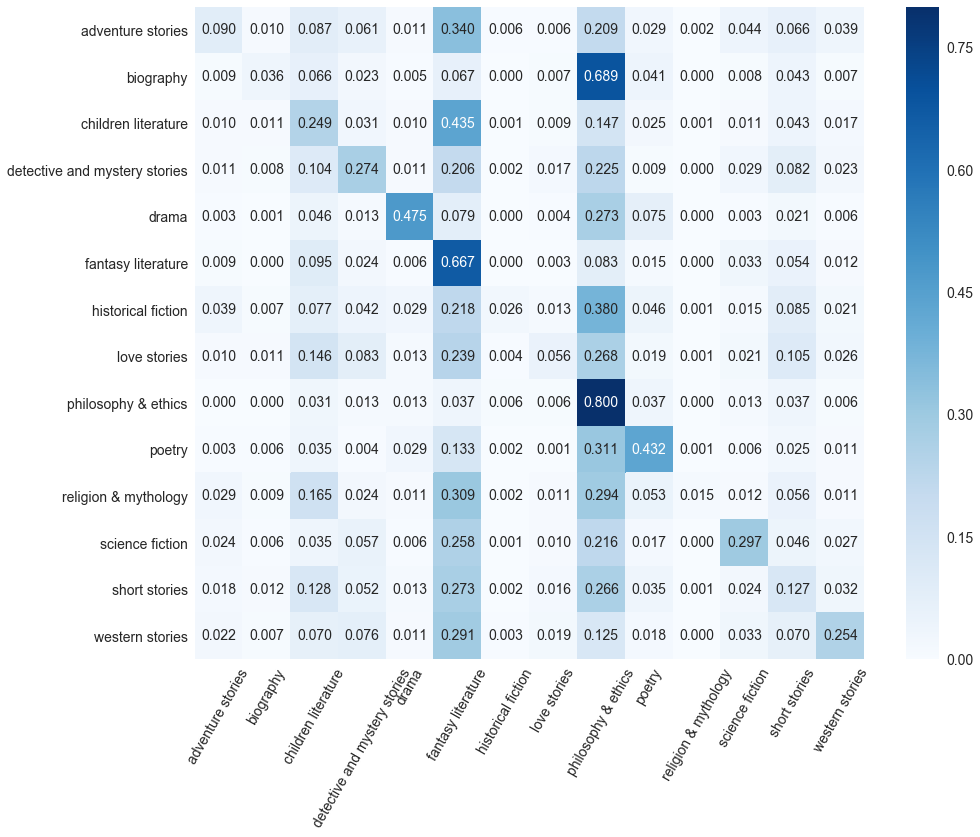

In [27]:
conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_test_pred),
             columns=le.classes_,
             index=le.classes_)

import seaborn as sns
sns.set(font_scale=1.4)
fig, ax = plt.subplots(1,1, figsize=(15,12))
row_sums = np.full_like(conf_matrix,conf_matrix.sum(axis=1).values).T
hm = sns.heatmap(conf_matrix / row_sums, annot=True, annot_kws={"size": 14}, fmt=".3f", cmap="Blues", ax=ax)
hm.set_xticklabels(hm.get_yticklabels(), rotation=60)
# display a table
display(conf_matrix)

# K nearest documents

In [ ]:
t = time.time()
step = 4000
X_test_sims = np.zeros([X_test.shape[0], 200])
for i in range(0, X_test.shape[0], step):
    if i % 1000 == 0:
        print(i)
    q = cosine_similarity(X_test[i:i+step], X_train)
    X_test_sims[i:i+step] = q.argsort(axis=1)[:,::-1][:,:200]